# UP42 SDK DEMO
UP42’s Python Software Development Kit (SDK) is a set of programming modules that integrates UP42’s powerful infrastructure for geospatial data & processing workflows. The Python package provides direct access to the UP42 Application Program Interface (API), data visualizations, and a Command Line Interface (CLI). The interfaces are built to empower customization, automation, and integration into any geospatial workflows.

To start using our SDK install the [up42-py package](https://pypi.org/project/up42-py/). You can find the UP42 SDK documentation [here](https://sdk.up42.com/).


### Tree height detection workflow
Railway operators must ensure secure uninterrupted transport. To achieve this they rely on effective monitoring and maintenance of their railway network. Tree falls onto railway tracks or overhead lines rank among the most common causes of disruptions of a natural origin [[Bíl et. al (2017)](https://www.researchgate.net/publication/318816940_Identifying_locations_along_railway_networks_with_the_highest_tree_fall_hazard)]. Thus, there is a need for regular inspections of vegetation inside and near the railway corridors to detect trees or tree branches that need to be cut. With UP42 you are able to get information on tree height using high resolution satellite imagery, for example [Pleiades](https://marketplace.up42.com/block/18d09f1a-3197-4c27-a15a-54d099c31435) or [SPOT](https://marketplace.up42.com/block/045019bb-06fc-4fa1-b703-318725b4d8af) data, in combination with the spacept  [Tree Detection and Height From Shadow](https://marketplace.up42.com/block/f5bf583e-dacb-489c-95b4-0e8be95accc9) block.

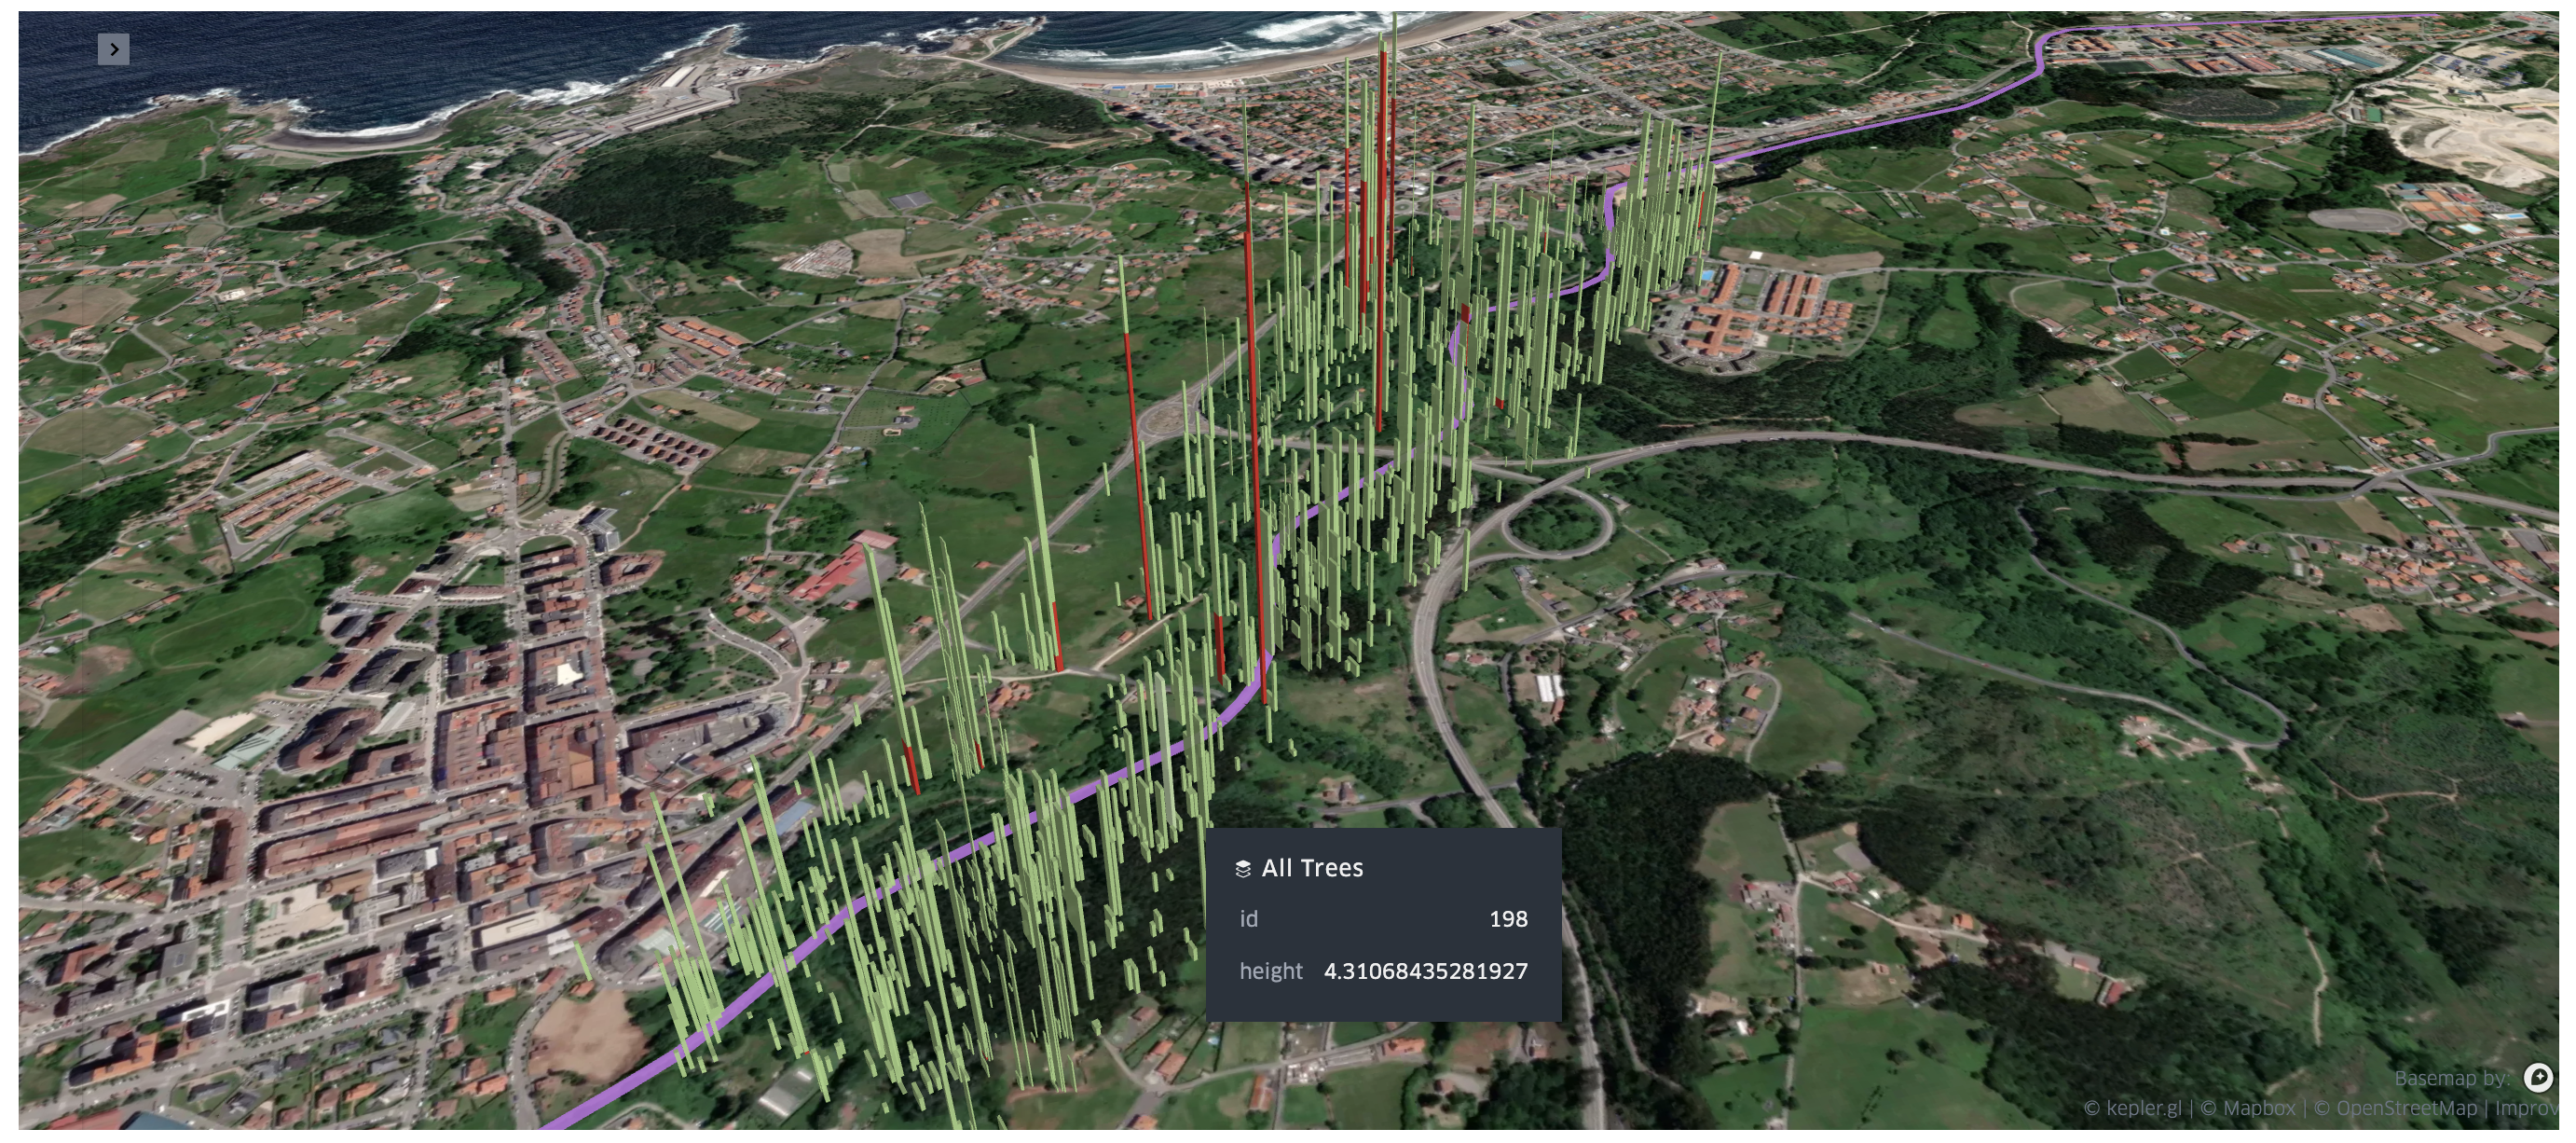

In [1]:
# import necessary libraries for workflow
import up42
from pprint import pprint
import geopandas as gpd
from keplergl import KeplerGl
from tree_height_utils import cleaning_data, get_kepler_config

#### 1. Authentication 

In [4]:
# authenticate with UP42 via your project credentials
alternative: up42.authenticate(project_id="1234", project_api_key="ABCD")

2021-05-14 08:13:33,317 - Authentication with UP42 successful!


#### 2. Initialize new project and create a new workflow

In [5]:
project = up42.initialize_project()

2021-05-14 08:13:34,365 - Initialized Project(name: Infrastructure Webinar, project_id: 85fc91ce-530f-4f60-90c6-d3e969e6e9f5, description: , createdAt: 2021-05-05T06:49:55.648022Z)


In [6]:
workflow = project.create_workflow(name="tree-height-workflow", use_existing=True)

2021-05-14 08:13:34,372 - Getting existing workflows in project ...
2021-05-14 08:13:34,807 - Got 2 workflows for project 85fc91ce-530f-4f60-90c6-d3e969e6e9f5.
100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
2021-05-14 08:13:35,745 - Using existing workflow: tree-height-workflow - 5b18113e-323b-4be8-a456-f3a5527ef5f7


#### 3. Select blocks for workflow (Pleiades + Raster Tiling + Tree height detection)

In [7]:
# to check available blocks at up42 do pprint(up42.get_blocks(basic=True))
input_tasks = [
    "oneatlas-pleiades-aoiclipped",
    "tiling",
    "tree-height-detection"
    ]
workflow.add_workflow_tasks(input_tasks)

2021-05-14 08:13:39,635 - Added tasks to workflow: [{'name': 'oneatlas-pleiades-aoiclipped:1', 'parentName': None, 'blockId': '18d09f1a-3197-4c27-a15a-54d099c31435'}, {'name': 'tiling:1', 'parentName': 'oneatlas-pleiades-aoiclipped:1', 'blockId': '3e146dd6-2b67-4d6e-a422-bb3d973e32ff'}, {'name': 'tree-height-detection:1', 'parentName': 'tiling:1', 'blockId': 'f5bf583e-dacb-489c-95b4-0e8be95accc9'}]


#### 4. Add parameters to workflow

In [8]:
# show required parameters
pprint(workflow.get_parameters_info())

2021-05-14 08:13:40,219 - Got 3 tasks/blocks in workflow 5b18113e-323b-4be8-a456-f3a5527ef5f7.


{'oneatlas-pleiades-aoiclipped:1': {'bbox': {'default': None, 'type': 'array'},
                                    'contains': {'type': 'geometry'},
                                    'ids': {'default': None, 'type': 'array'},
                                    'intersects': {'type': 'geometry'},
                                    'limit': {'default': 1,
                                              'maximum': 500,
                                              'minimum': 1,
                                              'type': 'integer'},
                                    'max_cloud_cover': {'default': 100,
                                                        'maximum': 100,
                                                        'minimum': 0,
                                                        'type': 'integer'},
                                    'panchromatic_band': {'default': False,
                                                          'type': 'boolean'},
       

In [9]:
# Define the aoi and input parameters of the workflow to run it
aoi = up42.read_vector_file("aux_files/aoi_asturias.geojson", as_dataframe=False)
# up42.draw_aoi()

In [10]:
input_parameters = workflow.construct_parameters(
                                        geometry=aoi, 
                                        geometry_operation="contains", 
                                        start_date="2019-02-12",
                                        end_date="2019-02-14",
                                        limit=1
                                    )

In [11]:
input_parameters["oneatlas-pleiades-aoiclipped:1"].update({"max_cloud_cover": 10})

#### 5. Check price with price estimation

In [12]:
# price estimation
workflow.estimate_job(input_parameters)

2021-05-14 08:13:50,976 - Estimated: 1476-1852 Credits, Duration: 0-0 min.


{'oneatlas-pleiades-aoiclipped:1': {'blockConsumption': {'resources': {'unit': 'TILE',
    'min': 73,
    'max': 73},
   'credit': {'min': 219, 'max': 219}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}},
 'tiling:1': {'blockConsumption': {'resources': {'unit': 'MEGABYTE',
    'min': 14.352384,
    'max': 14.352384},
   'credit': {'min': 0, 'max': 0}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 1, 'max': 1}}},
 'tree-height-detection:1': {'blockConsumption': {'resources': {'unit': 'SQUARE_KM',
    'min': 0.993923,
    'max': 1.2921},
   'credit': {'min': 1253, 'max': 1629}},
  'machineConsumption': {'duration': {'min': 0, 'max': 0},
   'credit': {'min': 2, 'max': 2}}}}

#### 6. Run dry run

In [13]:
# run a test job to query data availability and check the configuration
test_job = workflow.test_job(input_parameters, track_status=True)

2021-05-14 08:13:50,989 - +++++++++++++++++++++++++++++++++
2021-05-14 08:13:50,990 - Running this job as Test Query...
2021-05-14 08:13:50,991 - +++++++++++++++++++++++++++++++++
2021-05-14 08:13:50,992 - Selected input_parameters: {'oneatlas-pleiades-aoiclipped:1': {'time': '2019-02-12T00:00:00Z/2019-02-14T23:59:59Z', 'limit': 1, 'zoom_level': 18, 'max_cloud_cover': 10, 'panchromatic_band': False, 'contains': {'type': 'Polygon', 'coordinates': (((-5.959160327911377, 43.57086156472658), (-5.972743034362792, 43.558936168312364), (-5.9697604179382315, 43.55721013312703), (-5.9555768966674805, 43.56949345139266), (-5.959160327911377, 43.57086156472658)),)}}, 'tiling:1': {'tile_width': 768, 'tile_height': 768, 'match_extents': False, 'output_prefix': '', 'augmentation_factor': 1, 'discard_empty_tiles': True}, 'tree-height-detection:1': {}, 'config': {'mode': 'DRY_RUN'}}
2021-05-14 08:13:52,360 - Created and running new job: 54f8814b-c675-4380-a5ee-429ace722dad.
2021-05-14 08:13:52,860 - T

#### 7. Run job and download results

In [ ]:
# run the actual job
job = workflow.run_job(input_parameters, track_status=True)

In [ ]:
# download the job results
job.download_results()

#### Visualizing the results

In [2]:
# add path to data.json file
path_tree_results = "project_85fc91ce-530f-4f60-90c6-d3e969e6e9f5/job_9a412e30-985a-451d-8e36-397da77c001f/data.json"
# clean the data and create two geodataframes, one containing all trees the other containing only trees above 6m
all_trees_gdf, high_trees_gdf = cleaning_data(path_tree_results=path_tree_results)

In [3]:
# start keplergl basemap to plot tree heights in jupyter notebook
map_trees = KeplerGl(height=600)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [4]:
# read shapefile with railways in europe
train_lines = gpd.read_file('aux_files/train_line_asturias.shp')

In [5]:
# add each layer to map
map_trees.add_data(data=high_trees_gdf, name='high trees')
map_trees.add_data(data=all_trees_gdf, name='all trees')
map_trees.add_data(data=train_lines, name='train lines')

In [6]:
# visualize layers using kepler
map_trees

KeplerGl(data={'high trees': {'index': [21, 60, 251, 252, 258, 293, 297, 345, 351, 365, 393, 595, 600, 619, 62…

In [7]:
# add pre-configured configuration for better visualization
config = get_kepler_config()

In [8]:
map_trees.config = config

In [27]:
pprint(map_trees.config)

{'config': {'mapState': {'bearing': 12.732663821526033,
                         'dragRotate': True,
                         'isSplit': False,
                         'latitude': 43.56307771903234,
                         'longitude': -5.966771905350275,
                         'pitch': 54.847690688748024,
                         'zoom': 14.164356912639555},
            'mapStyle': {'mapStyles': {},
                         'styleType': 'satellite',
                         'threeDBuildingColor': [9.665468314072013,
                                                 17.18305478057247,
                                                 31.1442867897876],
                         'topLayerGroups': {},
                         'visibleLayerGroups': {}},
            'visState': {'animationConfig': {'currentTime': None, 'speed': 1},
                         'filters': [],
                         'interactionConfig': {'brush': {'enabled': False,
                                            